Import the libraries necessary to analize data

In [70]:
%matplotlib inline
import math
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt

from collections import defaultdict
from scipy.stats import pearsonr

Import the incidents csv file

In [71]:
df = pd.read_csv('incidents.csv', low_memory=False, sep=',') #alternative in case of json source df.to_json('filename.json')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   date                       239677 non-null  object 
 1   state                      239677 non-null  object 
 2   city_or_county             239677 non-null  object 
 3   address                    223180 non-null  object 
 4   latitude                   231754 non-null  float64
 5   longitude                  231754 non-null  float64
 6   congressional_district     227733 non-null  float64
 7   state_house_district       200905 non-null  float64
 8   state_senate_district      207342 non-null  float64
 9   participant_age1           147379 non-null  float64
 10  participant_age_group1     197558 non-null  object 
 11  participant_gender1        203315 non-null  object 
 12  min_age_participants       164879 non-null  object 
 13  avg_age_participants       16

Change data types to match the content of each attribute

In [72]:
df["date"] = df["date"].astype("datetime64[ns]")
df["state"] = df["state"].astype("string")
df["city_or_county"] = df["city_or_county"].astype("string")
df["address"] = df["address"].astype("string")
df["congressional_district"] = df["congressional_district"].astype("Int64")
df["state_house_district"] = df["state_house_district"].astype("Int64")
df["state_senate_district"] = df["state_senate_district"].astype("Int64")
df["participant_age1"] = df["participant_age1"].astype("Int64")
df["min_age_participants"] = pd.to_numeric(df["min_age_participants"], errors="coerce").astype("Int64")
df["max_age_participants"] = pd.to_numeric(df["max_age_participants"], errors="coerce").astype("Int64")
df["avg_age_participants"] = pd.to_numeric(df["avg_age_participants"], errors="coerce").astype("float64")
df[df['participant_gender1'] == 'Male, female'] = np.nan
df["participant_gender1"] = df["participant_gender1"].astype("string")
df["participant_age_group1"] = df["participant_age_group1"].astype("string")
df["n_participants_teen"] = pd.to_numeric(df["n_participants_teen"], errors="coerce").astype("Int64")
df["n_participants_child"] = pd.to_numeric(df["n_participants_child"], errors="coerce").astype("Int64")
df["n_participants_adult"] = pd.to_numeric(df["n_participants_adult"], errors="coerce").astype("Int64")
df["n_males"] = pd.to_numeric(df["n_males"], errors="coerce").astype("Int64")
df["n_females"] = pd.to_numeric(df["n_females"], errors="coerce").astype("Int64")
df["n_killed"] = pd.to_numeric(df["n_killed"], errors="coerce").astype("Int64")
df["n_injured"] = pd.to_numeric(df["n_injured"], errors="coerce").astype("Int64")
df["n_arrested"] = pd.to_numeric(df["n_arrested"], errors="coerce").astype("Int64")
df["n_unharmed"] = pd.to_numeric(df["n_unharmed"], errors="coerce").astype("Int64")
df["n_participants"] = pd.to_numeric(df["n_participants"], errors="coerce").astype("Int64")
df["notes"] = df["notes"].astype("string")
df["incident_characteristics1"] = df["incident_characteristics1"].astype("string")
df["incident_characteristics2"] = df["incident_characteristics2"].astype("string")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 239677 entries, 0 to 239676
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       239676 non-null  datetime64[ns]
 1   state                      239676 non-null  string        
 2   city_or_county             239676 non-null  string        
 3   address                    223179 non-null  string        
 4   latitude                   231753 non-null  float64       
 5   longitude                  231753 non-null  float64       
 6   congressional_district     227732 non-null  Int64         
 7   state_house_district       200904 non-null  Int64         
 8   state_senate_district      207341 non-null  Int64         
 9   participant_age1           147378 non-null  Int64         
 10  participant_age_group1     197557 non-null  string        
 11  participant_gender1        203314 non-null  string  

Deleting the rows with all NaN values

In [73]:
df.dropna(how='all', inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 239676 entries, 0 to 239676
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       239676 non-null  datetime64[ns]
 1   state                      239676 non-null  string        
 2   city_or_county             239676 non-null  string        
 3   address                    223179 non-null  string        
 4   latitude                   231753 non-null  float64       
 5   longitude                  231753 non-null  float64       
 6   congressional_district     227732 non-null  Int64         
 7   state_house_district       200904 non-null  Int64         
 8   state_senate_district      207341 non-null  Int64         
 9   participant_age1           147378 non-null  Int64         
 10  participant_age_group1     197557 non-null  string        
 11  participant_gender1        203314 non-null  string  

Import the povertyByStateYear csv file

In [74]:
poverty_df = pd.read_csv('povertyByStateYear.csv', sep=',')
poverty_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 884 entries, 0 to 883
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   state              884 non-null    object 
 1   year               884 non-null    int64  
 2   povertyPercentage  832 non-null    float64
dtypes: float64(1), int64(1), object(1)
memory usage: 20.8+ KB


Change data types to match the content of each attribute

In [75]:
poverty_df["state"] = poverty_df["state"].astype("string")
poverty_df["year"] = poverty_df["year"].astype("Int64")

Import the year_state_district_house csv file

In [76]:
district_in_state_df = pd.read_csv('year_state_district_house.csv', sep=',')
district_in_state_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10441 entries, 0 to 10440
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   year                    10441 non-null  int64 
 1   state                   10441 non-null  object
 2   congressional_district  10441 non-null  int64 
 3   party                   10441 non-null  object
 4   candidatevotes          10441 non-null  int64 
 5   totalvotes              10441 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 489.6+ KB


Change data types to match the content of each attribute

In [77]:
district_in_state_df["state"] = district_in_state_df["state"].astype("string")
district_in_state_df["year"] = district_in_state_df["year"].astype("Int64")
district_in_state_df["congressional_district"] = district_in_state_df["congressional_district"].astype("Int64")
district_in_state_df["party"] = district_in_state_df["party"].astype("string")
district_in_state_df["candidatevotes"] = district_in_state_df["candidatevotes"].astype("Int64")
district_in_state_df["totalvotes"] = district_in_state_df["totalvotes"].astype("Int64")

Analysing the distribution of the average age

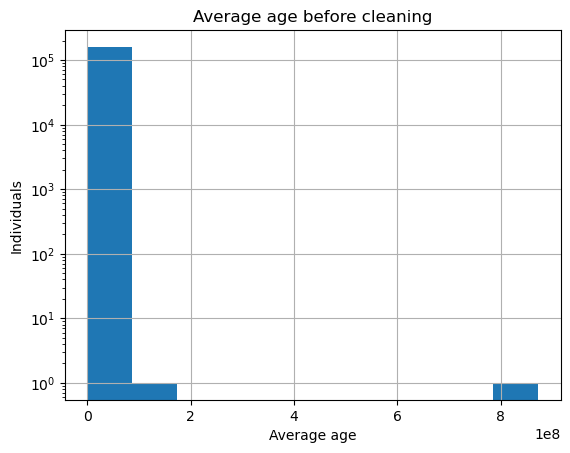

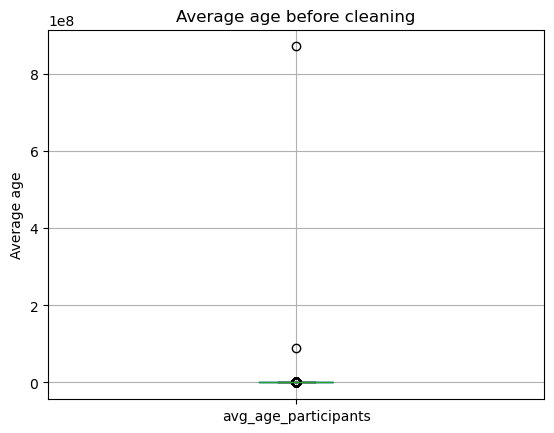

In [85]:
df.hist(column="avg_age_participants")
plt.title("Average age before cleaning")
plt.xlabel("Average age")
plt.ylabel("Individuals")
plt.yscale("log")
plt.show()

df.boxplot(column="avg_age_participants")
plt.title("Average age before cleaning")
plt.ylabel("Average age")
plt.show()

Given that there are some ouliers in the order of ~800 years of age, we decided to remove them by setting them all to NaN

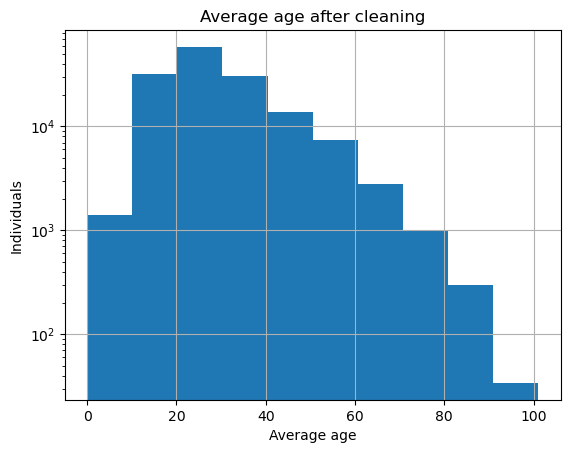

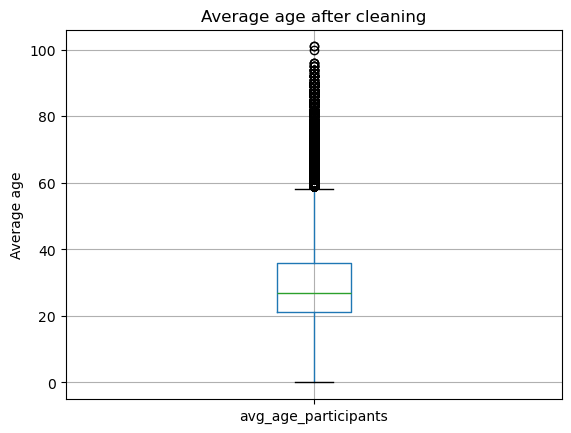

In [88]:
df.loc[(df["avg_age_participants"] > 120) | (df["avg_age_participants"] < 0), "avg_age_participants"] = np.nan

df.hist(column="avg_age_participants")
plt.title("Average age after cleaning")
plt.xlabel("Average age")
plt.ylabel("Individuals")
plt.yscale("log")
plt.show()

df.boxplot(column="avg_age_participants")
plt.title("Average age after cleaning")
plt.ylabel("Average age")
plt.show()

#df.loc[(df["min_age_participants"] > 120) | (df["min_age_participants"] < 0), "min_age_participants"] = np.nan
#df.loc[(df["max_age_participants"] > 120) | (df["max_age_participants"] < 0), "max_age_participants"] = np.nan
#df.loc[(df["participant_age1"] > 120) | (df["participant_age1"] < 0), "participant_age1"] = np.nan

#df[(df['participant_age1']).notna() == False & ((df['avg_age_participants'] < 0) | (df['avg_age_participants'] > 120)) ][["avg_age_participants","max_age_participants","participant_age1","min_age_participants","notes"]]

#setting nan the dates that are after 2023-10-01
df.loc[(df["date"] > "2023-10-01"), "date"] = np.nan

#setting nan the lonitudes and latitudes that are not in the US
df.loc[(df["latitude"] > 64.85694) |
        (df["latitude"] < 19.50139), ("latitude", "longitude")] = np.nan
df.loc[(df["longitude"] < -161.75583) |
        (df["longitude"] > -68.01197), ("longitude" , "latitude")] = np.nan

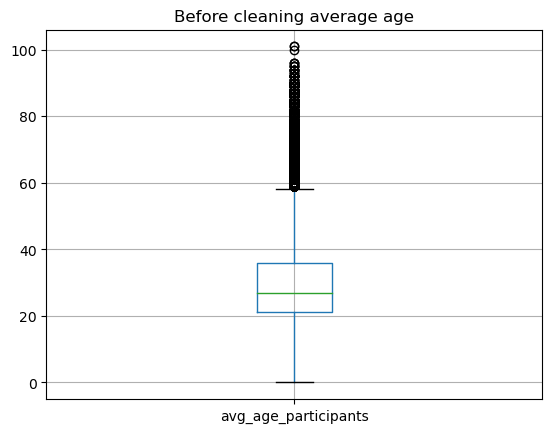

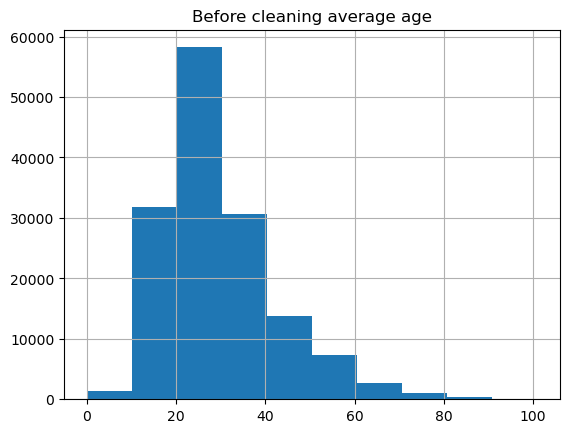

In [182]:
# Show plot before cleaning
#df[(df["avg_age_participants"] < 120) & (df["avg_age_participants"] >= 0) ].boxplot(column="avg_age_participants")
df.boxplot(column="avg_age_participants")
#count number of people with age > 60
#df[(df["avg_age_participants"] > 100)].count()
#plt.yscale('')
plt.title('Before cleaning average age')
plt.show()

#plotting an instogram of the average age
df[(df["avg_age_participants"] < 120) & (df["avg_age_participants"] >= 0) ].hist(column="avg_age_participants")
plt.title('Before cleaning average age')
plt.show()

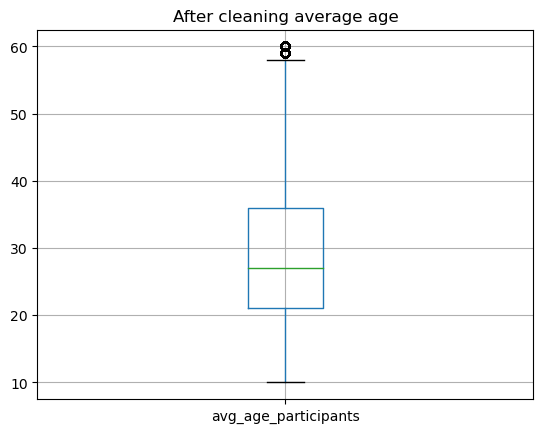

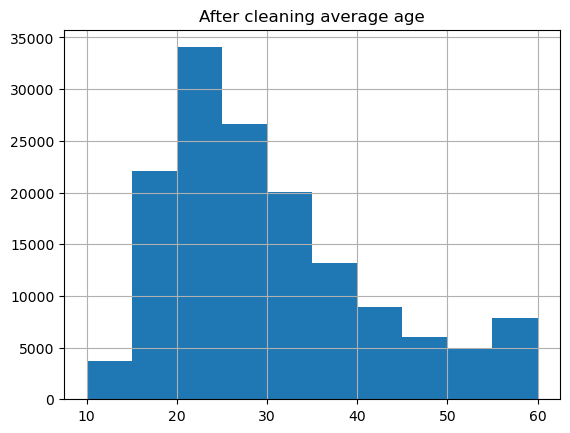

In [183]:
#setting ages to 10 if they are below 10
df.loc[(df["avg_age_participants"] < 10), "avg_age_participants"] = 10
#setting ages to 60 if they are above 60
df.loc[(df["avg_age_participants"] > 60), "avg_age_participants"] = 60

# Plotting dates before cleaning
df.boxplot(column="avg_age_participants")
plt.title('After cleaning average age')
plt.show()
df.hist(column="avg_age_participants")
plt.title('After cleaning average age')
plt.show()

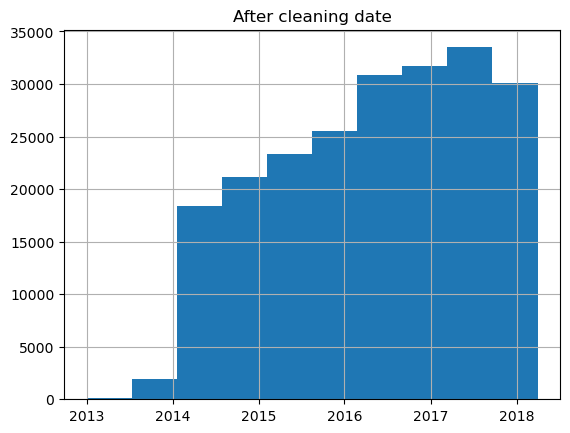

In [184]:
#plotting dates before cleaning
df.hist(column="date")
plt.title('After cleaning date')
plt.show()

In [185]:
print(len(df))
#print duplicates columns if they are not NaN
#df = df.drop_duplicates(subset=["date", "latitude", "longitude"]).append(df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])])
df = pd.concat([df[pd.isnull(df['date']) | pd.isnull(df['latitude']) | pd.isnull(df['longitude'])], df.drop_duplicates(subset=["date", "latitude", "longitude"])])
df.drop_duplicates(inplace=True)
print(len(df))

239676
238287


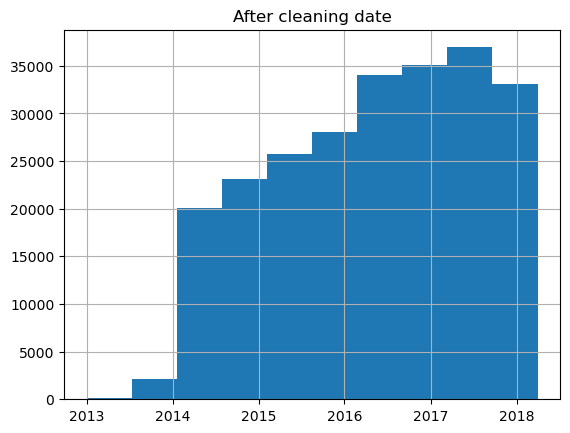

In [186]:
#Substituting the NaN values with the "mode"
#df.loc[(pd.isna(df["date"])), "date"] = "2017-10-01"

#Assigning a value from a Random biased distribution, based on the dates
df.loc[(pd.isna(df["date"])), "date"] = np.random.choice(df["date"].dropna(), size=len(df[pd.isna(df["date"])]))

#plotting dates before cleaning
df.hist(column="date")
plt.title('After cleaning date')
plt.show()


In [187]:
#Sostituisco i valori NaN di latitude e longitude, con i valori delle righe aventi lo stesso state e la stessa city_or_county
df[['latitude', 'longitude']] = df.groupby(["state", "city_or_county"])[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df[['latitude', 'longitude']] = df.groupby("state")[['latitude', 'longitude']].apply(lambda x: x.fillna(x.mean()))
df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 238287 entries, 4 to 239676
Data columns (total 28 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   date                       238287 non-null  datetime64[ns]
 1   state                      238287 non-null  string        
 2   city_or_county             238287 non-null  string        
 3   address                    222129 non-null  string        
 4   latitude                   238287 non-null  float64       
 5   longitude                  238287 non-null  float64       
 6   congressional_district     226355 non-null  Int64         
 7   state_house_district       199690 non-null  Int64         
 8   state_senate_district      206080 non-null  Int64         
 9   participant_age1           146710 non-null  Int64         
 10  participant_age_group1     196686 non-null  string        
 11  participant_gender1        202428 non-null  string  

In [120]:
#dp_df = df[df.duplicated(keep=False)]
#dp_df = df.groupby(['date','latitude','longitude']).any()
#dp_df = df.drop_duplicates()
#dp_df

columns_to_check = ["n_arrested", "n_females", "n_injured", "n_males", "n_participants",
                    "n_killed", "n_participants_adult", "n_participants_child",
                    "n_participants_teen", "n_unharmed"]
# Set values less than 0 to NaN for the specified columns
for i in columns_to_check:
    df[df[i] < 0] = np.nan






In [121]:
for cl in dp_df.columns:
    x = dp_df[cl].unique()



NameError: name 'dp_df' is not defined

In [ ]:
dp_df.describe()

In [ ]:
dp_df.corr()

In [ ]:
#remove age greater than 80s
dp_df = dp_df[dp_df['participant_age1'] < 80]
pd.plotting.scatter_matrix(dp_df[['participant_age1', 'n_injured', 'n_killed']])
plt.show()

In [ ]:
plt.scatter(dp_df[dp_df['participant_age1'] < 18]['participant_age1'],
            dp_df[dp_df['participant_age1'] < 18]['n_injured'], color='y', marker='*', label='< 18')

plt.scatter(dp_df[dp_df['participant_age1'] > 17]['participant_age1'],
            dp_df[dp_df['participant_age1'] > 17]['n_injured'], color='r',label='> 18')
plt.xlabel('participant_age1')
plt.ylabel('n_injured')
plt.legend()
plt.show()

In [ ]:
#plot matrix with different colors for correlation
plt.matshow(dp_df.corr())
#legend for correlation
#add names of columns
plt.yticks(range(len(dp_df.columns)), dp_df.columns)
plt.colorbar()
plt.show()
